In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import zipfile
import os

In [ ]:
import zipfile

zip_path = '/content/archive.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted {zip_path} to {extract_path}")

Extracted /content/archive.zip to /content/


In [ ]:
PATH = '10_food_classes_10_percent'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            shuffle = True,
                                                            image_size = IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
for images, labels in train_dataset.take(1):
  print(f'Images shape: {images.shape}')
  print(f'Labels Shapes:{labels.shape}')
  print(f'Labels:{labels.numpy()}')

Images shape: (32, 224, 224, 3)
Labels Shapes:(32,)
Labels:[9 9 4 7 3 5 4 5 4 1 1 9 7 0 0 3 4 6 4 9 5 5 2 6 1 7 7 4 7 7 0 9]


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


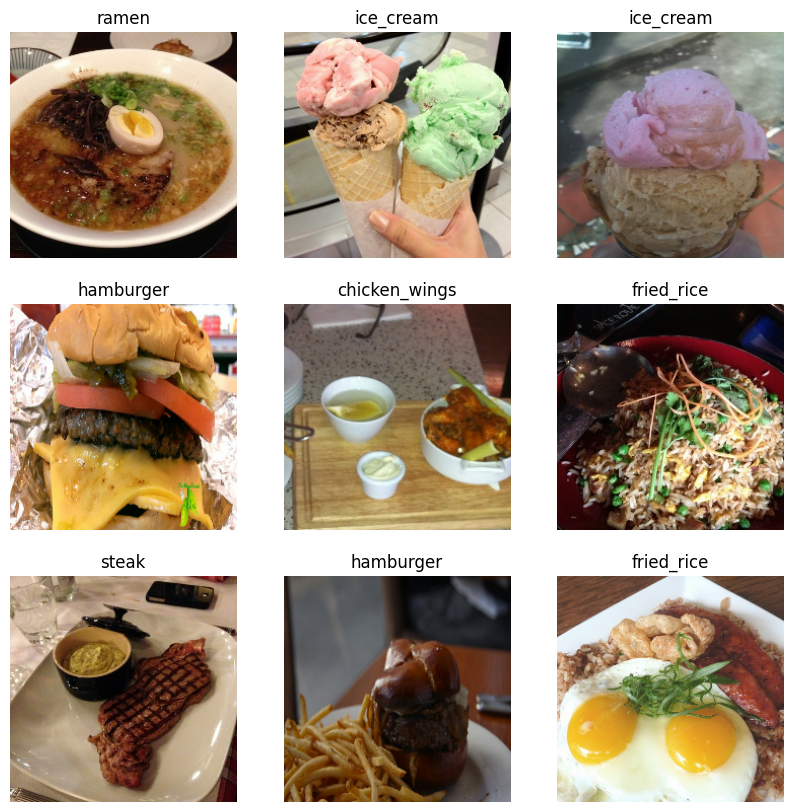

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 24
Number of validation batches: 16
Number of test batches: 63


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False

In [ ]:
image_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # THE OUT OF THIS FUCTION IS ACTUALLY THE FEATURE LEARNINIG SIDE OF THE MOBILENETV2

(32, 7, 7, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# here instead of straightening the complete tensor that we got from the previous batch we use (global avg pooling)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10,activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.0859 - loss: 2.7278


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0962 - loss: 2.8196
Epoch 1: val_loss improved from inf to 2.46572, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.0964 - loss: 2.8171 - val_accuracy: 0.1260 - val_loss: 2.4657 - learning_rate: 1.0000e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1199 - loss: 2.5279
Epoch 2: val_loss improved from 2.46572 to 2.28432, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.1205 - loss: 2.5267 - val_accuracy: 0.1550 - val_loss: 2.2843 - learning_rate: 1.0000e-04
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1736 - loss: 2.3685
Epoch 3: val_loss improved from 2.28432 to 2.12853, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.1740 - loss: 2.3687 - val_accuracy: 0.2149 - val_loss: 2.1285 - learning_rate: 1.0000e-04
Epoch 4/100
23/24 ━━━━━━━━━━━━━━━━━━

In [ ]:
loss1, accuracy1 = model.evaluate(test_dataset)
print('Test loss :', loss1)
print('Test accuracy :', accuracy1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7819 - loss: 0.7369
Test loss : 0.7344456315040588
Test accuracy : 0.7832341194152832


In [ ]:
history_df = pd.DataFrame(history.history)

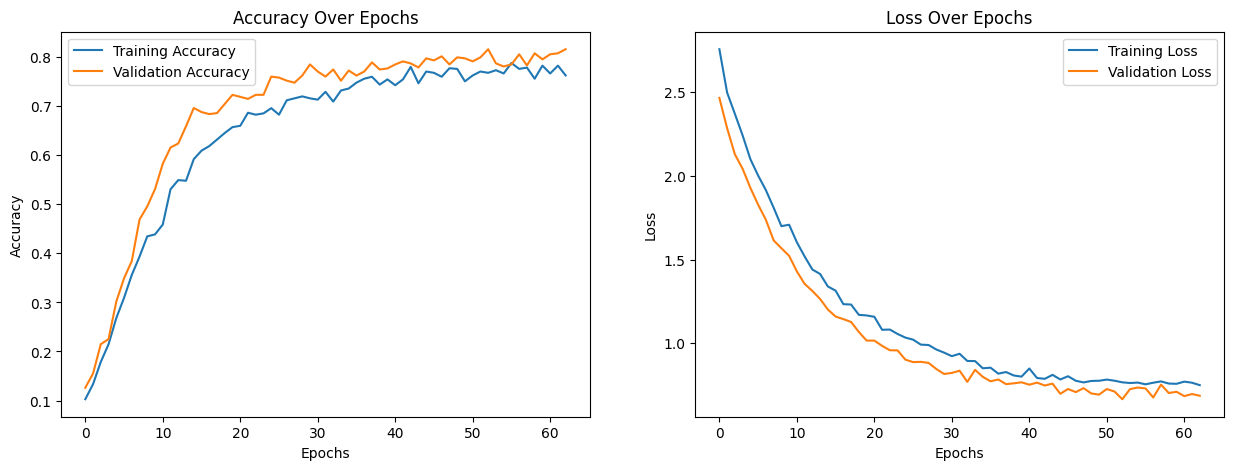

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

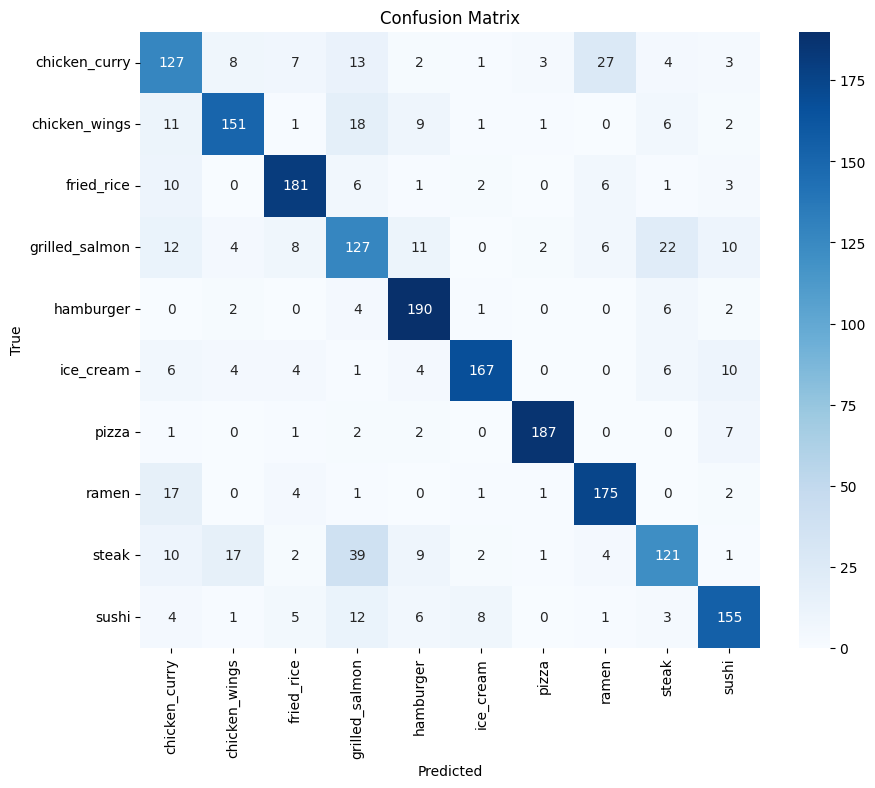

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

38

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,637,706 (6.25 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset,
                         callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 64/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4129 - loss: 1.7034
Epoch 64: val_loss did not improve from 0.66574
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.4132 - loss: 1.7023 - val_accuracy: 0.8120 - val_loss: 0.6781 - learning_rate: 1.0000e-05
Epoch 65/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4734 - loss: 1.4971
Epoch 65: val_loss improved from 0.66574 to 0.66338, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.4758 - loss: 1.4920 - val_accuracy: 0.8058 - val_loss: 0.6634 - learning_rate: 1.0000e-05
Epoch 66/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5276 - loss: 1.4188
Epoch 66: val_loss improved from 0.66338 to 0.63432, saving model to best_tuned_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.5291 - loss: 1.4114 - val_accuracy: 0.8099 - val_loss: 0.6343 - learning_rate: 1.0000e-05
Epoch 67/200
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6194

In [ ]:
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test loss :', loss2)
print('Test accuracy :', accuracy2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8192 - loss: 0.5916
Test loss : 0.5970467329025269
Test accuracy : 0.8184523582458496


In [ ]:
history_fine_df = pd.DataFrame(history_fine.history)
history_fine_df.index += len(history_df)

In [ ]:
history_full_df = pd.concat([history_df, history_fine_df])

In [ ]:
finetune_start_epoch = len(history_df)

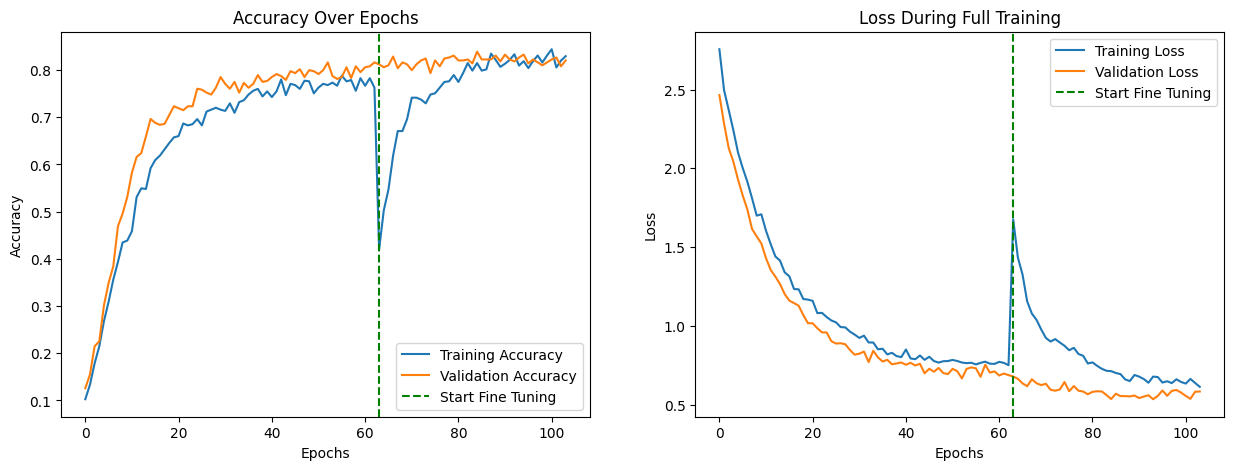

In [ ]:
plt.figure(figsize=(15, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history_full_df['accuracy'], label='Training Accuracy')
plt.plot(history_full_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history_full_df['loss'], label='Training Loss')
plt.plot(history_full_df['val_loss'], label='Validation Loss')
plt.axvline(x=finetune_start_epoch, linestyle='--', color='green', label='Start Fine Tuning')
plt.title("Loss During Full Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

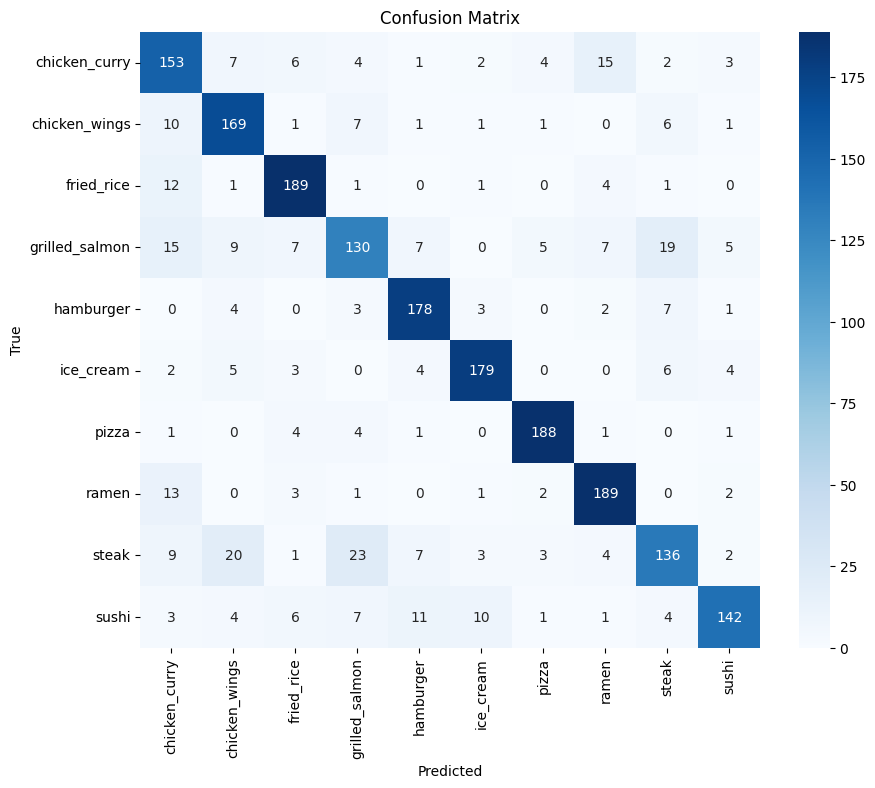

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print comparison side by side
print("\nComparison:")
print(f"{'Metric':<15}{'Base Model':<15}{'Fine Tuning'}")
print(f"{'-'*40}")
print(f"{'Loss':<15}{loss1:<15.4f}{loss2:.4f}")
print(f"{'Accuracy':<15}{accuracy1:<15.4f}{accuracy2:.4f}")


Comparison:
Metric         Base Model     Fine Tuning
----------------------------------------
Loss           0.7344         0.5970
Accuracy       0.7832         0.8185


Predictions:
 [3 4 4 4 5 1 4 5 1 3 5 6 4 4 1 8 1 0 1 4 4 5 9 3 4 2 8 2 2 8 5 1]
Labels:
 [3 4 4 4 5 1 4 5 1 3 5 0 6 4 1 8 1 0 1 9 4 5 9 3 4 2 1 2 2 9 5 1]


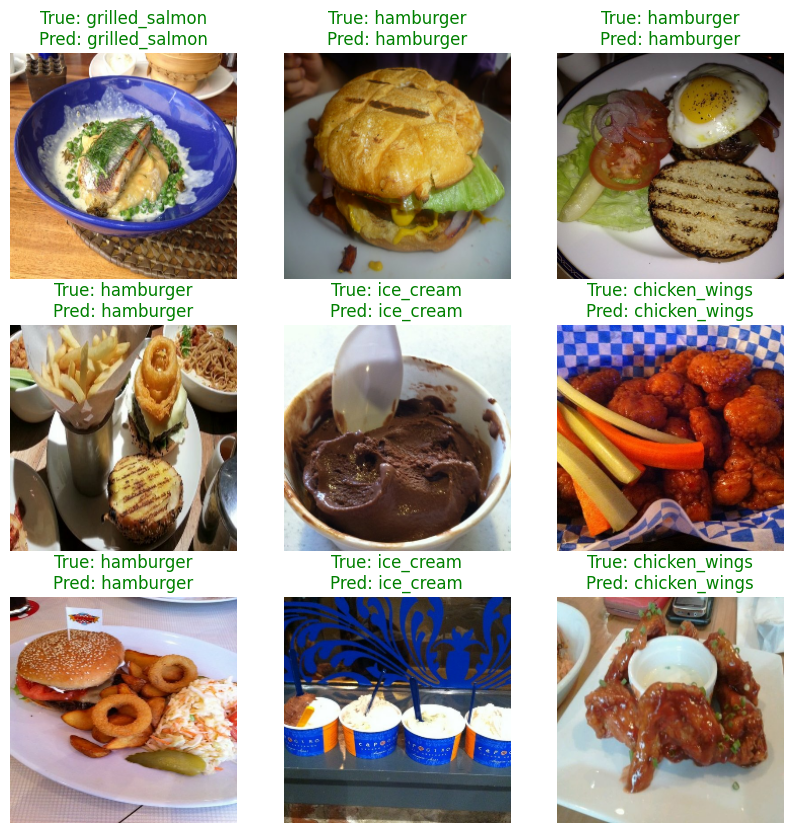

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]
  predicted_label = class_names[predicted_classes[i]]
  plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
  plt.axis("off")